In [1]:
# 📓 Notebook : Classification multimodale séquentielle CNN + Transformer

# 📦 Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout,
    LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D,
    TimeDistributed, Concatenate, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import json


2025-07-21 16:08:44.481058: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-21 16:08:44.636336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753106924.704544  954569 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753106924.726131  954569 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753106924.876599  954569 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
def features_exist(path_list):
    return all(os.path.exists(p) for p in path_list)


In [3]:

# --- Dossiers (à adapter)
image_dir_le = 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM'
image_dir_sub = 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Subtracted images of CDD-CESM'
json_dir = 'CDD-CESM/json_output'
excel_path = 'processed_metadata.csv'

X_img_train_feats_path = 'model/X_img_train_feats.npy'
X_img_val_feats_path = 'model/X_img_val_feats.npy'
X_img_test_feats_path = 'model/X_img_test_feats.npy'


# --- Fonction de chargement séquentiel des 8 images (chaque image 224x224x1)
def load_images_sequential_partial(patient_id):
    paths = [
        f"{image_dir_le}/P{patient_id}_L_DM_CC.jpg",
        f"{image_dir_le}/P{patient_id}_L_DM_MLO.jpg",
        f"{image_dir_sub}/P{patient_id}_L_CM_CC.jpg",
        f"{image_dir_sub}/P{patient_id}_L_CM_MLO.jpg",
        f"{image_dir_le}/P{patient_id}_R_DM_CC.jpg",
        f"{image_dir_le}/P{patient_id}_R_DM_MLO.jpg",
        f"{image_dir_sub}/P{patient_id}_R_CM_CC.jpg",
        f"{image_dir_sub}/P{patient_id}_R_CM_MLO.jpg",
    ]
    imgs = []
    valid_found = False
    for p in paths:
        if os.path.exists(p):
            try:
                img = Image.open(p).convert('L').resize((224, 224))
                arr = np.array(img) / 255.0
                arr = arr[..., np.newaxis]
                valid_found = True
            except:
                arr = np.zeros((224, 224, 1), dtype=np.float32)
        else:
            arr = np.zeros((224, 224, 1), dtype=np.float32)
        imgs.append(arr)
    return np.stack(imgs, axis=0) if valid_found else None


# --- Chargement des métadonnées
meta_df = pd.read_csv(excel_path)
meta_df = meta_df.dropna(subset=['Patient_ID', 'Pathology Classification/ Follow up'])
meta_df['Patient_ID'] = meta_df['Patient_ID'].astype(str)

# --- Chargement textes JSON
texts = []
for pid in meta_df['Patient_ID']:
    path = os.path.join(json_dir, f"P{pid}.json")
    if os.path.exists(path):
        with open(path, encoding="utf-8") as f:
            try:
                d = json.load(f)
                flat_text = []
                for v in d.values():
                    flat_text.extend(map(str, v) if isinstance(v, list) else [str(v)])
                texts.append(" ".join(flat_text))
            except:
                texts.append("")
    else:
        texts.append("")


In [4]:

# --- Echantillonnage 80%
sampled_df = meta_df.sample(frac=0.8, random_state=42)
sampled_patient_ids = sampled_df['Patient_ID'].tolist()


In [5]:

# --- Chargement séquentiel des images + labels
images = []
valid_labels = []
valid_pids = []
skipped_image = 0

for pid, label in zip(sampled_df['Patient_ID'], sampled_df['Pathology Classification/ Follow up']):
    imgs_seq = load_images_sequential_partial(pid)
    if imgs_seq is not None:
        images.append(imgs_seq)
        valid_labels.append(label)
        valid_pids.append(pid)
    else:
        skipped_image += 1



In [6]:

# --- Alignement des données
image_patient_ids = set(valid_pids)
text_patient_ids = set(sampled_patient_ids)
metadata_patient_ids = set(meta_df['Patient_ID'])
common_patient_ids = list(image_patient_ids & text_patient_ids & metadata_patient_ids)

image_dict = {pid: img for pid, img in zip(valid_pids, images) if pid in common_patient_ids}
label_dict = {pid: label for pid, label in zip(valid_pids, valid_labels) if pid in common_patient_ids}
text_dict = {pid: text for pid, text in zip(sampled_patient_ids, texts) if pid in common_patient_ids}
meta_dict = {pid: meta_df[meta_df['Patient_ID'] == pid].iloc[0] for pid in common_patient_ids}

images_filtered = np.array([image_dict[pid] for pid in common_patient_ids])  # shape (N, 8, 224, 224, 1)
labels_filtered = [label_dict[pid] for pid in common_patient_ids]
texts_filtered = [text_dict[pid] for pid in common_patient_ids]
meta_df_filtered = pd.DataFrame([meta_dict[pid] for pid in common_patient_ids])


In [7]:

# --- Textes vectorisés
vectorizer = TfidfVectorizer(max_features=1000)
text_features_filtered = vectorizer.fit_transform(texts_filtered).toarray()


In [8]:

# --- Encodage des métadonnées
numerical = meta_df_filtered.select_dtypes(include=['float', 'int']).columns.tolist()
categorical = meta_df_filtered.select_dtypes(include=['object']).drop(columns=['Patient_ID', 'Pathology Classification/ Follow up']).columns.tolist()

scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False)

meta_num_filtered = scaler.fit_transform(meta_df_filtered[numerical])
meta_cat_filtered = encoder.fit_transform(meta_df_filtered[categorical])
meta_features_filtered = np.concatenate([meta_num_filtered, meta_cat_filtered], axis=1)

# --- Encodage des labels
valid_labels_encoded, label_names = pd.factorize(labels_filtered)
labels_cat = to_categorical(valid_labels_encoded)

# --- Poids de classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(valid_labels_encoded), y=valid_labels_encoded)
class_weight_dict = dict(enumerate(class_weights))


/tmp/ipykernel_954569/1470660569.py:13: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  valid_labels_encoded, label_names = pd.factorize(labels_filtered)


In [9]:

# --- Split train/test
X_img_temp, X_img_test, X_meta_temp, X_meta_test, X_txt_temp, X_txt_test, y_temp, y_test = train_test_split(
    images_filtered, meta_features_filtered, text_features_filtered, labels_cat,
    test_size=0.1, random_state=42)

X_img_train, X_img_val, X_meta_train, X_meta_val, X_txt_train, X_txt_val, y_train, y_val = train_test_split(
    X_img_temp, X_meta_temp, X_txt_temp, y_temp,
    test_size=0.2, random_state=42)


In [10]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Lambda, TimeDistributed, Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

# --- CNN préentraîné médical (RadImageNet = proche IRM/CT)
def create_radimagenet_encoder():
    base_model = DenseNet121(
        include_top=False,
        weights=None,  # on charge manuellement après
        input_shape=(224, 224, 3)
    )
    # Charger les poids RadImageNet
    base_model.load_weights("weights/RadImageNet-DenseNet121_notop.h5")

    base_model.trainable = False  # pour garder les features médicales

    inputs = Input(shape=(224, 224, 1), name="img_input_gray")
    x = Lambda(lambda img: tf.image.grayscale_to_rgb(img))(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    return Model(inputs, x, name="radimagenet_densenet_encoder")



In [11]:

# --- TransformerBlock déjà défini plus tôt
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [12]:

# Inputs
img_seq_input = Input(shape=(8, 224, 224, 1), name='img_seq_input')

# CNN encoder partagé
cnn_encoder = create_radimagenet_encoder()
x_img_seq = TimeDistributed(cnn_encoder)(img_seq_input)
x_img_seq = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)(x_img_seq)
x_img_seq = tf.keras.layers.GlobalAveragePooling1D()(x_img_seq)

# Classification
x = Dense(128, activation='relu')(x_img_seq)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(len(label_names), activation='softmax')(x)

# Modèle image-only
cnn_model = Model(inputs=img_seq_input, outputs=output)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2025-07-21 16:15:18.771759: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
from tqdm.keras import TqdmCallback

if features_exist([X_img_train_feats_path, X_img_val_feats_path, X_img_test_feats_path]):
    print("🔄 Chargement des features extraites du modèle CNN...")
    X_img_train_feats = np.load(X_img_train_feats_path)
    X_img_val_feats = np.load(X_img_val_feats_path)
    X_img_test_feats = np.load(X_img_test_feats_path)
else:
    print("🚀 Entraînement du modèle CNN et extraction des features...")

    # Phase 1 : entraînement CNN
    history_phase1 = cnn_model.fit(
        X_img_train,
        y_train,
        validation_data=(X_img_val, y_val),
        epochs=30,
        batch_size=16,
        class_weight=class_weight_dict,
        callbacks=[TqdmCallback(verbose=1)]
    )

    # Extraction des features
    cnn_feature_extractor = Model(inputs=img_seq_input, outputs=x_img_seq)
    cnn_feature_extractor.trainable = False

    X_img_train_feats = cnn_feature_extractor.predict(X_img_train)
    X_img_val_feats = cnn_feature_extractor.predict(X_img_val)
    X_img_test_feats = cnn_feature_extractor.predict(X_img_test)

    # Sauvegarde pour les prochains runs
    np.save(X_img_train_feats_path, X_img_train_feats)
    np.save(X_img_val_feats_path, X_img_val_feats)
    np.save(X_img_test_feats_path, X_img_test_feats)


🔄 Chargement des features extraites du modèle CNN...


In [21]:
# Inputs multimodaux
img_feat_input = Input(shape=(64,), name='cnn_img_feat')
meta_input = Input(shape=(X_meta_train.shape[1],), name='meta_input')
text_input = Input(shape=(X_txt_train.shape[1],), name='text_input')

# Embedding
x_img = Dense(64, activation='relu')(img_feat_input)
x_meta = Dense(64, activation='relu')(meta_input)
x_text = Dense(64, activation='relu')(text_input)

# Concat et Transformer
x = Concatenate(axis=-1)([x_img, x_meta, x_text])  # (batch, 192)
x = Lambda(lambda x: tf.expand_dims(x, axis=1))(x)  # (batch, 1, 192)
x = TransformerBlock(embed_dim=192, num_heads=4, ff_dim=256)(x)
x = GlobalAveragePooling1D()(x)

# Classification finale
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(len(label_names), activation='softmax')(x)

model_phase2 = Model(inputs=[img_feat_input, meta_input, text_input], outputs=output)
model_phase2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_phase2.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_img_feat        │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_input          │ (None, 586)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 354)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      4,160 │ cnn_img_feat[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 64)        │     37,568 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │     22,720 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 192)       │          0 │ dense_14[0][0],   │
│ (Concatenate)       │                   │            │ dense_15[0][0],   │
│                     │                   │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1, 192)    │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_2 │ (None, 1, 192)    │    691,840 │ lambda_2[0][0]    │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 128)       │     24,704 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_19[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │      8,256 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 64)        │          0 │ dense_20[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 3)         │        195 │ dropout_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 789,443 (3.01 MB)

 Trainable params: 789,443 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy'
    patience=3,          # stop after 3 epochs without improvement
    restore_best_weights=True
)

history_phase2 = model_phase2.fit(
    [X_img_train_feats, X_meta_train, X_txt_train], y_train,
    validation_data=([X_img_val_feats, X_meta_val, X_txt_val], y_val),
    epochs=50,  # large max value, early stopping will halt sooner
    batch_size=16,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.3436 - loss: 1.3617 - val_accuracy: 0.3276 - val_loss: 1.0855
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3180 - loss: 1.1843 - val_accuracy: 0.3276 - val_loss: 1.0972
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3755 - loss: 1.1032 - val_accuracy: 0.3276 - val_loss: 1.1030
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3428 - loss: 1.1003 - val_accuracy: 0.3276 - val_loss: 1.0833
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3439 - loss: 1.1448 - val_accuracy: 0.5172 - val_loss: 1.0582
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3991 - loss: 1.0662 - val_accuracy: 0.4828 - val_loss: 1.0022
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5456 - loss: 0.9692 - val_accuracy: 0.6552 - val_loss: 0.9912
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5962 - loss: 0.9162 - val_accuracy: 0.5000 - v

In [23]:
def create_finetune_cnn_encoder(trainable=True):
    base_model = DenseNet121(
        include_top=False,
        weights=None,
        input_shape=(224, 224, 3)
    )
    base_model.load_weights("weights/RadImageNet-DenseNet121_notop.h5")
    base_model.trainable = trainable  # ❗️ Débloqué pour fine-tuning

    inputs = Input(shape=(224, 224, 1), name="img_input_gray")
    x = Lambda(lambda img: tf.image.grayscale_to_rgb(img))(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=trainable)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    return Model(inputs, x, name="finetune_cnn_encoder")


In [17]:
# # --- Modèle multimodal complet (Phase 3)
# img_seq_input = Input(shape=(8, 224, 224, 1), name='img_seq_input')
# meta_input = Input(shape=(X_meta_train.shape[1],), name='meta_input')
# text_input = Input(shape=(X_txt_train.shape[1],), name='text_input')

# cnn_encoder_finetune = create_finetune_cnn_encoder()
# x_img_seq = TimeDistributed(cnn_encoder_finetune)(img_seq_input)
# x_img_seq = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)(x_img_seq)
# x_img_seq = GlobalAveragePooling1D()(x_img_seq)

# x_meta = Dense(64, activation='relu')(meta_input)
# x_text = Dense(64, activation='relu')(text_input)

# x = Concatenate()([x_img_seq, x_meta, x_text])
# x = Lambda(lambda x: tf.expand_dims(x, axis=1))(x)
# x = TransformerBlock(embed_dim=192, num_heads=4, ff_dim=256)(x)
# x = GlobalAveragePooling1D()(x)

# x = Dense(128, activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.2)(x)
# output = Dense(len(label_names), activation='softmax')(x)

# model_phase3 = Model(inputs=[img_seq_input, meta_input, text_input], outputs=output)
# model_phase3.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-6),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# model_phase3.summary()



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
              precision    recall  f1-score   support

      Benign       0.67      0.67      0.67         9
      Normal       0.80      0.71      0.75        17
   Malignant       0.44      0.57      0.50         7

    accuracy                           0.67        33
   macro avg       0.64      0.65      0.64        33
weighted avg       0.69      0.67      0.67        33

F1-score: 0.6742424242424242
Accuracy: 0.6666666666666666
ROC AUC: [0.7962963  0.73161765 0.7032967 ]


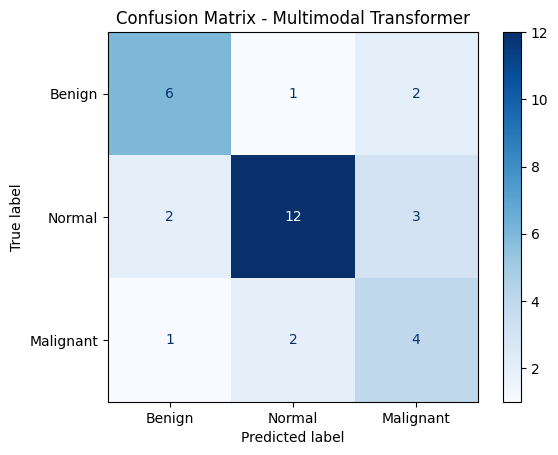

In [24]:

# --- Évaluation sur test
# Prédictions
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Prédictions
y_pred_phase2 = model_phase2.predict([X_img_test_feats, X_meta_test, X_txt_test])
y_pred_classes = np.argmax(y_pred_phase2, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Scores
print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))
print("F1-score:", f1_score(y_true_classes, y_pred_classes, average='weighted'))
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))

# ROC AUC
print("ROC AUC:", roc_auc_score(y_test, y_pred_phase2, average=None, multi_class='ovr'))

# Matrice de confusion
cm = confusion_matrix(y_true_classes, y_pred_classes)
ConfusionMatrixDisplay(cm, display_labels=label_names).plot(cmap='Blues')
plt.title("Confusion Matrix - Multimodal Transformer")
plt.show()


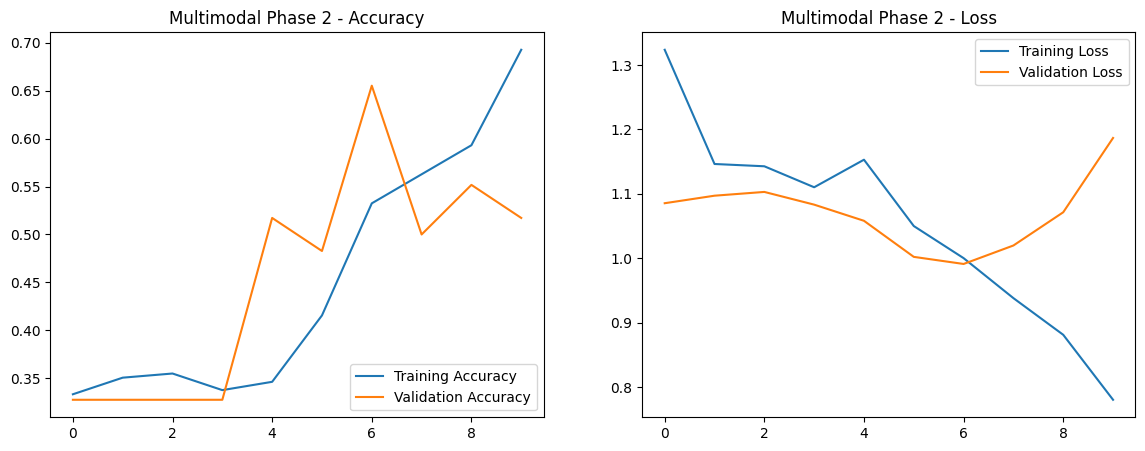

In [25]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Training History"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')

    plt.show()

# Appel pour phase 2
# plot_training_history(history_phase1, title="CNN Phase 1")
plot_training_history(history_phase2, title="Multimodal Phase 2")



In [26]:
# 📥 Sauvegarde des métriques dans un CSV
import csv
from sklearn.metrics import precision_score, recall_score
from datetime import datetime
import os

# Calcul des métriques
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true_classes, y_pred_classes)

# Heure actuelle
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Nom du fichier script / notebook (si exécuté depuis un fichier)
try:
    filename = os.path.basename(__file__)
except NameError:
    # Si exécuté dans un notebook Jupyter
    filename = "notebook"

# Chemin du CSV
metrics_file = "model_metrics_log.csv"

# Vérifie si le fichier existe déjà
file_exists = os.path.isfile(metrics_file)

# Sauvegarde en ajoutant une ligne
with open(metrics_file, mode='a', newline='') as file:
    writer = csv.writer(file)
    if not file_exists:
        # Écrire l'en-tête si le fichier est nouveau
        writer.writerow(["timestamp", "filename", "precision", "recall", "f1_score", "accuracy", "roc_auc"])
    writer.writerow([timestamp, filename, precision, recall, f1, accuracy, 0])
